# Atık Sınıflandırıcı (Ön Eğitilmil VGG ile)

Bu not defteri Maskeli ve maskesiz insan yüzü görüntülerini sınıflandırmak için Evrişimsel sinir ağı modeli oluşturmayı amaçlamaktadır.

Veri seti kaggle üzerinden elde edilmiştir.
https://www.kaggle.com/techsash/waste-classification-data

Aşağıdaki python komutu colab <-> drive bağlantısını sağlayacaktır.
isteğe bağlı olduğu için yorum satırı olarak yazılmıştır

In [1]:
#from google.colab import drive
#drive.mount('/content/drive/')

#Veriseti indiriliyor (Dataset Download)
Kaggle Api kullanarak verisetini indiriyoruz. 

Verisetini indirmek için aşağıdaki kod parçasında bazı değişiklikler yapılması gerekebilir. api_token isimli değişkenin işaret ettiği alandaki username ve key alanlarının değerlerini değiştirerek komutun çalışmasını sağlayabilirsiniz. Aşağıdaki kod bloğu kaggle komutunun çalışabilmesi için oturum doğrulama problemini çözer.

In [2]:
!pip install kaggle
api_token = {"username":"pativo7635","key":"3c3d6cb0f1cf3c0b47aefcd8be93494a"}
import json
import zipfile
import os
if not os.path.exists('/content/.kaggle/'):
  os.mkdir('/content/.kaggle/')
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /content/.kaggle/kaggle.json
!kaggle config path -p /content

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


/content/.kaggle/kaggle.json konumunda kaggle.json dosyasının olduğunu ve içeriğini kontrol edin.

In [3]:
!cat /content/.kaggle/kaggle.json

{"username": "pativo7635", "key": "3c3d6cb0f1cf3c0b47aefcd8be93494a"}

Bu komut .kaggle dosyasını /root/ dizinine taşır. Kaggle komutunun çalışabilmesi için gereklidir.

In [4]:
!mv /content/.kaggle/ /root/

Bu komut ile veri setini zip dosyası halinde colab çalışma alanınıza indirebilirsiniz. (Veri setini kendi bilgisayarınıza indirip google drive'a aktarmaktan çok daha hızlı ve problemsiz olur.)

In [5]:
!kaggle datasets download -d techsash/waste-classification-data

 99% 422M/427M [00:03<00:00, 169MB/s]
100% 427M/427M [00:03<00:00, 132MB/s]


Zip dosyasını ayıklıyoruz. Bu sayede veriseti colab çalışma ortamında kolaylıkla erişilebilir hale geliyor. dilerseniz. mv yada cp linuz komutlarını kullanarak veri setinizi drive hesabınıza aktarabilirsiniz.

In [6]:
zip_ref = zipfile.ZipFile('/content/waste-classification-data.zip', 'r')
zip_ref.extractall()
zip_ref.close()

Dosyalar bir önceki döngüde çıkarılmıştı bu nedenle es geçtim.

# Kütüphaneler içe aktarılıyor (import library)
Kullanacağımız kütüphaneleri import ediyoruz.

In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tensorflow versiyonunu ekrana yazdırmak .ipynb notebook paylaşıldığında paylaşılan kişilerin versiyon bilgisine kolayca ulaşmasını sağlar. Bu notebooklar kod dökümantasyonunu kolaylaştırmayı hedeflemektedir.

In [8]:
print(tf.__version__)

2.4.0


# Veri seti (Dataset)
Veri üç parçaya ayrılmış. Bunu yapmaları büyük incelik çünkü eğer onlar yapmasa biz uğraşacaktık. Ayrıca klasör isimleri ile sınıflandırmalarıda çok hoş. ayrı bir dosyadan okumak gerekmemesi çok iyi olmuş. İncelediğim benzer amaçlı veri setlerinde yüz bulunan kısımlar kırpılmamıştı. sadece yüz bulunan alan koordinatları verilmişti. Yani bir dünya ön işleme gerekiyordu. Sonra kaggleda bu veriseti gözüme takıldı dedimki Budur! :))

In [9]:
print("Veriset Klasörü: ", os.listdir('/content/'))


Veriset Klasörü:  ['.config', 'DATASET', 'waste-classification-data.zip', 'dataset', 'sample_data']


Burada kodu yönetebilmek adına dizin yolarını (path) değişkenlere tanımlıyoruz. Böylece bu dizinleri tekrar tekrar yazmamız gerekmeyecek.

In [10]:
!mkdir '/content/DATASET/'
!mkdir '/content/DATASET/VALIDATION/'
!mkdir '/content/DATASET/VALIDATION/O'
!mkdir '/content/DATASET/VALIDATION/R'

mkdir: cannot create directory ‘/content/DATASET/’: File exists


In [11]:
#os.listdir(os.path.join('/content/traindata/traindata/','men'))
import shutil

In [12]:
base_dir = '/content/DATASET/'
train_dir = os.path.join(base_dir,'TRAIN')
validation_dir = os.path.join(base_dir, 'VALIDATION')
test_dir = os.path.join(base_dir, 'TEST')

for i,file in enumerate(os.listdir(os.path.join(train_dir,'O'))):
  if(i == 100): #eğer yüzde 10'a geldiysen dur 
    break
  shutil.move(os.path.join(os.path.join(train_dir,'O'),file), os.path.join(os.path.join(validation_dir,'O'), file))

for j,file in enumerate(os.listdir(os.path.join(train_dir,'R'))):
  if(j == 200): #eğer yüzde 10'a geldiysen dur 
    break
  shutil.move(os.path.join(os.path.join(train_dir,'R'),file), os.path.join(os.path.join(validation_dir,'R'), file))

In [13]:
train_o = os.path.join(train_dir, 'O')
train_r = os.path.join(train_dir, 'R')

val_o = os.path.join(validation_dir, 'O')
val_r = os.path.join(validation_dir, 'R')

test_o = os.path.join(test_dir, 'O')
test_r = os.path.join(test_dir, 'R')

Burada dizinlerdeki dosya sayılarını ekrana yazdırıyoruz ve ilgili değişkenlere kaydediyoruz.

In [14]:
count_train_o = len(os.listdir(train_o))
count_train_r = len(os.listdir(train_r))

print("Eğitim Kümesindeki O Etiketli Görüntüsü Sayısı: ", count_train_o)
print("Eğitim Kümesindeki R Etiketli Görüntüsü Sayısı: ", count_train_r)

count_val_o = len(os.listdir(val_o))
count_val_r = len(os.listdir(val_r))

print("Doğrulama Kümesindeki O Etiketli Görüntüsü Sayısı: ", count_val_o)
print("Doğrulama Kümesindeki R Etiketli Görüntüsü Sayısı: ", count_val_r)

count_test_o = len(os.listdir(test_o))
count_test_r = len(os.listdir(test_r))

print("Test Kümesindeki O Etiketli Görüntüsü Sayısı: ", count_test_o)
print("Test Kümesindeki R Etiketli Görüntüsü Sayısı: ", count_test_r)

Eğitim Kümesindeki O Etiketli Görüntüsü Sayısı:  12465
Eğitim Kümesindeki R Etiketli Görüntüsü Sayısı:  9799
Doğrulama Kümesindeki O Etiketli Görüntüsü Sayısı:  100
Doğrulama Kümesindeki R Etiketli Görüntüsü Sayısı:  200
Test Kümesindeki O Etiketli Görüntüsü Sayısı:  1401
Test Kümesindeki R Etiketli Görüntüsü Sayısı:  1112


Aşağıdaki kod Eğitim Doğrulama ve Test için ayrılan verilerin miktarını bir sutun grafiği şeklinde görüntüler.

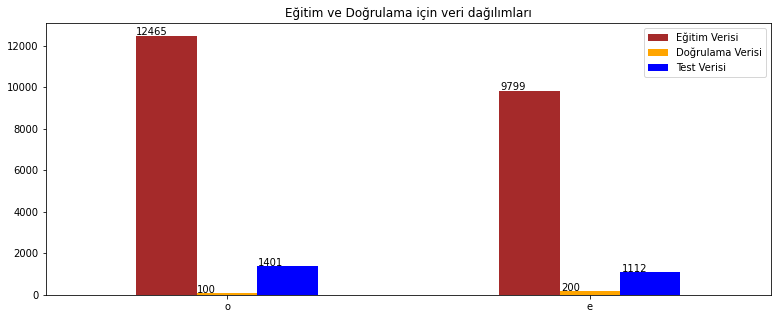

In [15]:
tr = [count_train_o, count_train_r]
va = [count_val_o, count_val_r]
te = [count_test_o, count_test_r]
index = ['o', 'e']
data_am = pd.DataFrame({'Eğitim Verisi': tr, 'Doğrulama Verisi': va, 'Test Verisi': te }, index=index)
ax = data_am.plot.bar(rot=0, color=['brown', 'orange','blue'], figsize=(13,5))
ax.set_title("Eğitim ve Doğrulama için veri dağılımları")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

Aşağıda ImageDataGenerator adı verilen nesneler tanımlanıyor. Bu nesneler sayesinde ileride elimizdeki veri miktarından daha fazla veriye sahip olacağız. Elimizdeki görüntülere bazı görüntü işleme yöntemleri (dönderme, yeniden boyutlandıma, yansıtma vb.) uygulanarak görüntü miktarı arttırılır.

In [16]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')
 
validation_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

Yukarıda tanımlanan ImageDataGeneratorler kullanılarak veriler oluşturuluyor.

In [17]:
train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(150, 150),  
        batch_size=32,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_dir, 
        target_size=(150, 150), 
        batch_size=32, 
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir, 
        target_size=(150, 150), 
        batch_size=32, 
        class_mode='categorical')

Found 22264 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [18]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

conv_base.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

# Model oluşturuluyor. (Model Build)
katmanlar

In [20]:
# model katmanları belirleniyor. Convolutional Neural Network
model = tf.keras.models.Sequential([
  conv_base,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation= 'relu'),
  tf.keras.layers.Dense(2, activation= 'sigmoid')
])

Model özetleniyor.

In [21]:
# Modelin özeti ekrana yazdırılıyor.
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 16,812,610
Trainable params: 9,177,346
Non-trainable params: 7,635,264
_________________________________________________________________
None


model derleniyor

In [22]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

In [23]:
# Doğruluk(Accuracy) %90'a ulaştığında eğitimi durduracak bir callback kullanmak.
# veriseti çok büyük olmadığı için verinin ezberlenmemesi için.
accuracythreshold = 90e-2 #eşil değeri bu satırdan değiştirilebilir.
class AccCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy') >= accuracythreshold):   
          print("\nDoğruluk %2.2f%% 'ye ulaştı. Eğitim durdu!" %(accuracythreshold*100))   
          self.model.stop_training = True

#Eğitim (Train)
Eğitime bşlanıyor

In [24]:
# Eğitim başlatılıyor ve eğitim geçmişi kaydediliyor.
history = model.fit(
    train_generator,
    steps_per_epoch = 25,
    epochs = 20,
    validation_data = validation_generator,
    validation_steps = 5,
    verbose = 2,
    callbacks=[AccCallback()])

Epoch 1/20
25/25 - 14s - loss: 18.0550 - accuracy: 0.5525 - val_loss: 0.7022 - val_accuracy: 0.3250
Epoch 2/20
25/25 - 6s - loss: 0.6879 - accuracy: 0.5825 - val_loss: 0.7110 - val_accuracy: 0.3812
Epoch 3/20
25/25 - 6s - loss: 0.7075 - accuracy: 0.5900 - val_loss: 0.6565 - val_accuracy: 0.5625
Epoch 4/20
25/25 - 6s - loss: 1.7908 - accuracy: 0.6263 - val_loss: 2.1951 - val_accuracy: 0.6750
Epoch 5/20
25/25 - 6s - loss: 0.8039 - accuracy: 0.6925 - val_loss: 1.2650 - val_accuracy: 0.7375
Epoch 6/20
25/25 - 6s - loss: 0.7389 - accuracy: 0.7237 - val_loss: 0.4161 - val_accuracy: 0.8313
Epoch 7/20
25/25 - 6s - loss: 0.6329 - accuracy: 0.7550 - val_loss: 0.5399 - val_accuracy: 0.7563
Epoch 8/20
25/25 - 6s - loss: 0.5127 - accuracy: 0.7987 - val_loss: 0.3277 - val_accuracy: 0.8938
Epoch 9/20
25/25 - 6s - loss: 0.4874 - accuracy: 0.8125 - val_loss: 0.4056 - val_accuracy: 0.8750
Epoch 10/20
25/25 - 6s - loss: 0.4764 - accuracy: 0.8250 - val_loss: 0.2763 - val_accuracy: 0.9062
Epoch 11/20
25/25

# Eğitim Sonuçları (Train Results)

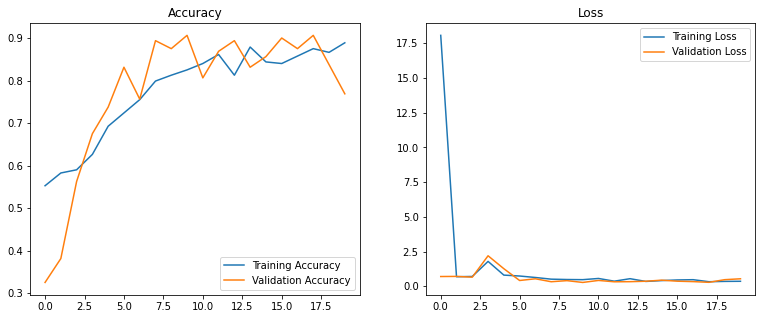

In [25]:
%matplotlib inline
from matplotlib import pyplot as plt
# Doğruluk ve kayıp grafikleri görselleştiriliyor.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

# Test

Şimdi modelimiz hazır :)

Bi bakalım ona bir resim versek doğru algılayabiliyor mu?

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[0]


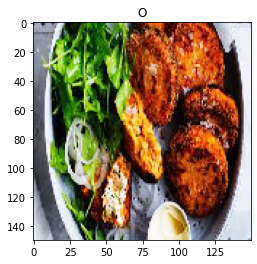

[1]


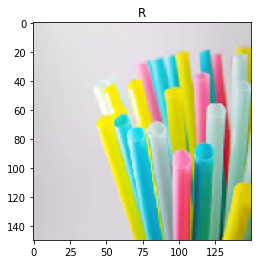

In [26]:
from keras.preprocessing import image
import numpy as np
get_label_name = ['O','R']

image_path="/content/DATASET/TEST/O/O_12893.jpg"
img = image.load_img(image_path, target_size=(150, 150))
plt.imshow(img)
img = np.expand_dims(img, axis=0)
result=model.predict_classes(img)
print(result)
plt.title(get_label_name[list(result)[0]])

plt.show()

image_path="/content/DATASET/TEST/R/R_10661.jpg"
img = image.load_img(image_path, target_size=(150, 150))
plt.imshow(img)
img = np.expand_dims(img, axis=0)
result=model.predict_classes(img)
print(result)
plt.title(get_label_name[list(result)[0]])

plt.show()

Aşağıda gerçek değerlerin kaydedileceği ve modelin tahminlerinin kaydedileceği liste türünde iki değişken tanımlanıyor.

In [28]:
actuals = []
predictions = []

Burada Tıbbi maske takan insan yüzlerinin olduğu test görüntüleri için model tahminde bulunuyor. 5. satırda gerçek değer 0 olarak actuals listesine ekleniyor. buradaki bütün görüntüler test_WithMask dosyasından okunuyor. 16. satırda tahmin değerleri predictions listesine kaydediliyor.

Test verisi çok fazla olduğu için ve test edebilmek için bunları ram'de tutmamız gerektiği için sadece sınırlı sayıda görüntü ile test yaptım

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


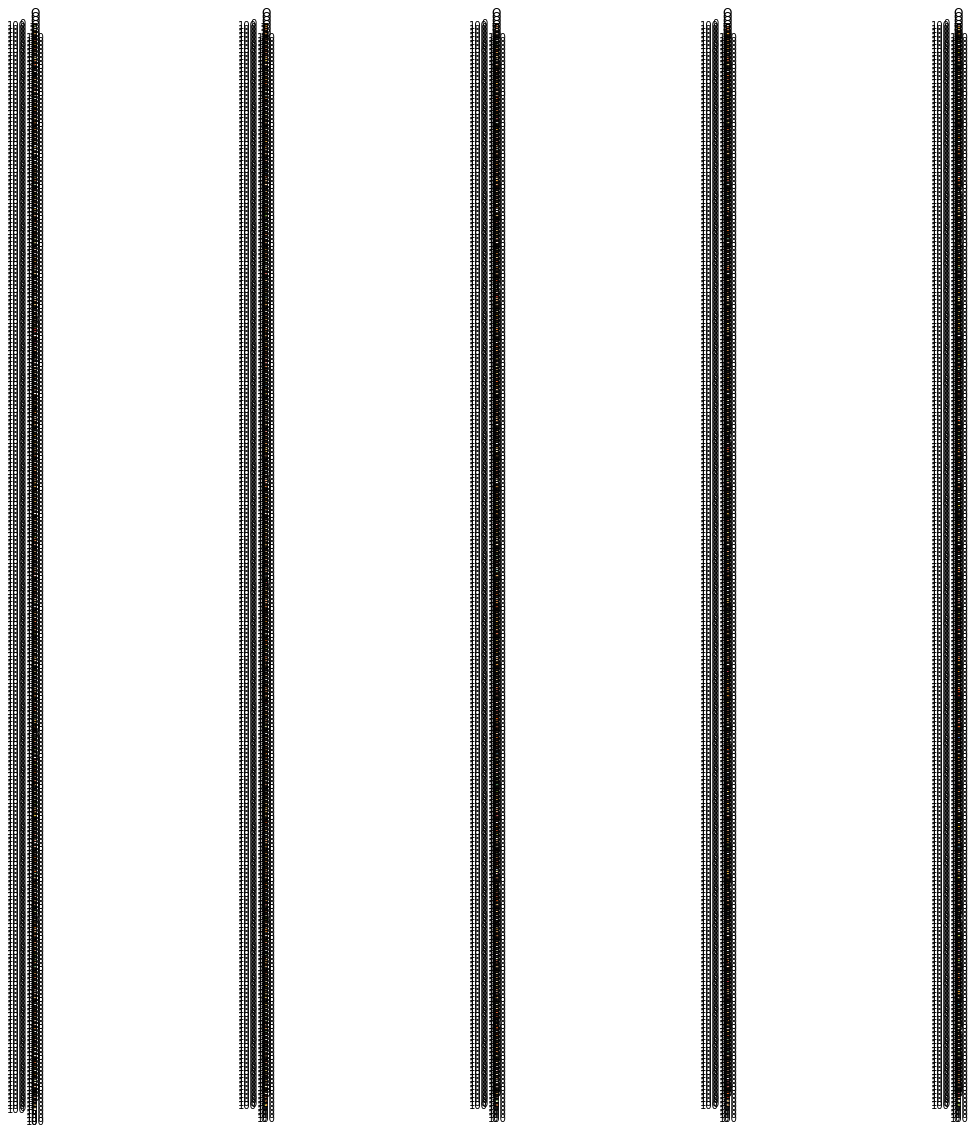

In [29]:
img_dir=test_o
batch_holder = np.zeros((len(os.listdir(img_dir)), 150, 150, 3))

for i,img in enumerate(os.listdir(img_dir)):
  actuals.append(0)
  img = image.load_img(os.path.join(img_dir,img), target_size=(150,150))
  batch_holder[i, :] = img

result=model.predict_classes(batch_holder)
fig = plt.figure(figsize=(20, 20))

for i,img in enumerate(batch_holder):
  fig.add_subplot((len(os.listdir(img_dir))/5)+1,5, i+1)
  plt.title(get_label_name[list(result)[i]])
  predictions.append(list(result)[i])
  plt.imshow(img/256.)
  
plt.show()

Burada Tıbbi maske takmayan insan yüzlerinin olduğu test görüntüleri için model tahminde bulunuyor. 5. satırda gerçek değer 1 olarak actuals listesine ekleniyor. buradaki bütün görüntüler test_WithoutMask dosyasından okunuyor. 16. satırda tahmin değerleri predictions listesine kaydediliyor.

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


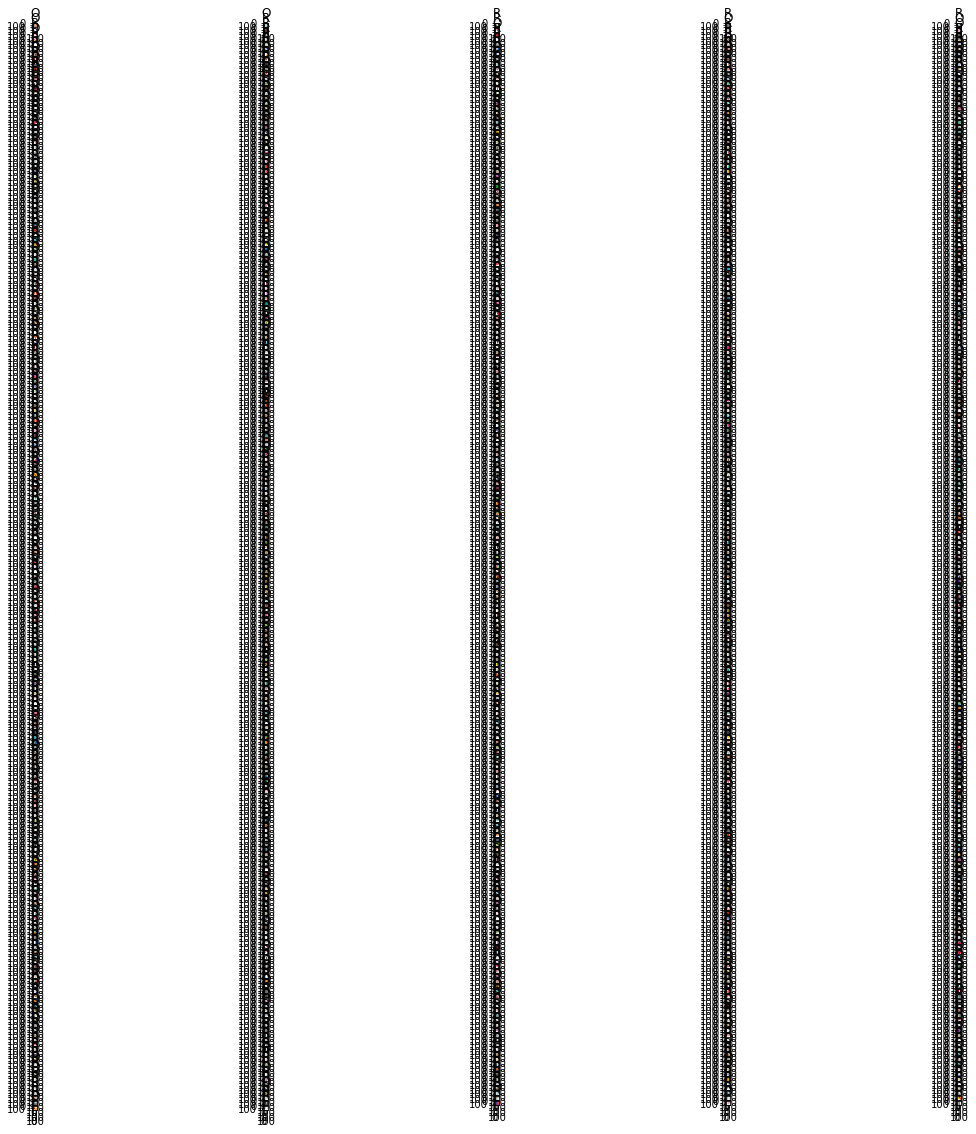

In [30]:
img_dir=test_r
batch_holder = np.zeros((len(os.listdir(img_dir)), 150, 150, 3))

for i,img in enumerate(os.listdir(img_dir)):
  actuals.append(1)
  img = image.load_img(os.path.join(img_dir,img), target_size=(150,150))
  batch_holder[i, :] = img

result=model.predict_classes(batch_holder)

fig = plt.figure(figsize=(20, 20))

for i,img in enumerate(batch_holder):
  fig.add_subplot((len(os.listdir(img_dir))/5)+1,5, i+1)
  plt.title(get_label_name[list(result)[i]])
  predictions.append(list(result)[i])
  plt.imshow(img/256.)
  
plt.show()

Asıl değerler ve tahminler liste şeklinde ekrana yazdırılıyor.

In [33]:
print(actuals)
print(predictions)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Aşağıdaki matriste dikey eksen asıl değerleri ifade eder.
Yatay eksen ise tahmin edilen değerleri ifade eder.
```
0: O (Organik Atık)
1: R (Inorganik Atık)
```

#Karışıklık matrisi (Confusion Matrix)

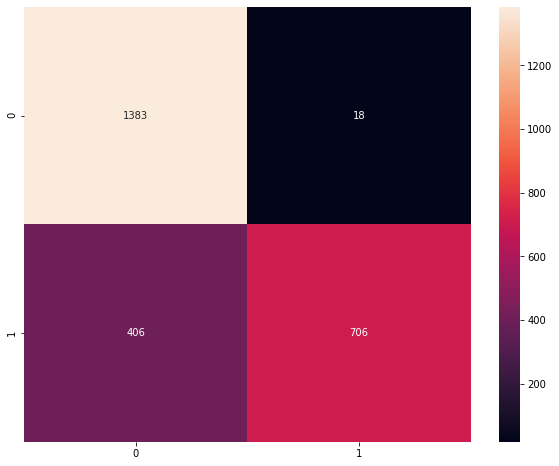

In [34]:
# Creating the confusion matrix graphs
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt
cf_train_matrix = confusion_matrix(actuals, predictions)
plt.figure(figsize=(10,8))
sns.heatmap(cf_train_matrix, annot=True, fmt='d')